# Neo4j Python Client
In the examples that follows, we will be using the Neo4j python client
[Neo4j python client](https://neo4j.com/developer/python/)

## Setup Neo4j instance
Create a free account at [https://sandbox.neo4j.com](https://sandbox.neo4j.com). Choose the "Blank Sandbox - Graph Data Science" option.

When your sandbox has been created, fill in the Bolt URL and password below.

In the examples that follows, we will be using the new PySpark graphdatascience client library.

## Setup Neo4j Python client imports

In [1]:
from neo4j import GraphDatabase
import pandas as pd
import warnings

Import visualization libraries for analyzing dataframes in this notebook.

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
neo4j_url = "bolt://<ip>:7687"
neo4j_user = "neo4j"
neo4j_password = "<pwd>"
neo4j_database= "neo4j"

Create a helper class Neo4jConnection for working with the Neo4j python client.

In [68]:
class Neo4jPythonClient:

    def __init__(self, uri, user, pwd):

        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None

        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):

        if self.__driver is not None:
            self.__driver.close()

    def query(self, query, parameters=None, db=None):

        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None

        try:
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

    def queryToDf(self, query, parameters=None, db=None):

        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None

        try:
            warnings.filterwarnings(
                "ignore",
                message=r"^pandas support is experimental and might be changed or removed in future versions$",
            )
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = session.run(query, parameters).to_df()
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

    def queryToPrint(self, query, parameters=None, db=None):
        print(self.queryToDf(query,parameters,db))

Create connection to Python client

In [33]:
gdbClient = Neo4jPythonClient(uri=neo4j_url, user=neo4j_user, pwd=neo4j_password)

In [70]:
gds_version_query = """return gds.version() as gds_version"""
gdbClient.queryToPrint(gds_version_query)

  gds_version
0       2.0.1


Test Python client by checking if there are records currently in the database.

In [71]:
count_nodes_query = """MATCH (n) RETURN count(n) as count"""
gdbClient.queryToPrint(count_nodes_query)

   count
0    392


If there are records, wipe out the database

In [31]:
reset_db = gdbClient.queryToPrint("CREATE OR REPLACE DATABASE `"+neo4j_database+"`")

Empty DataFrame
Columns: []
Index: []


Recheck the database

# Load MSA data

Create MSA unique constraint

In [35]:
gdbClient.query("""
CREATE CONSTRAINT msa_name IF NOT EXISTS ON (m:MSA) ASSERT m.name IS NODE KEY
""")

[]

In [36]:
load_csv_query = """
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/smithna/datasets/main/CensusDemographicsByMetroArea.csv'
AS row
WITH row WHERE row.name CONTAINS 'Metro'
MERGE (m:MSA {name:row.name})
SET m.population = toInteger(row.population),
m.medianHouseholdIncome = toInteger(row.medianHouseholdIncome),
m.medianHomePrice = toInteger(row.medianHomePrice),
m.percentOver25WithBachelors = toFloat(row.percentOver25WithBachelors)
RETURN count(m) as msaCount"""

gdbClient.queryToPrint(load_csv_query)

   msaCount
0       392


Start by creating a [node key constraint](https://neo4j.com/docs/cypher-manual/current/constraints/) that requires that each MSA node has a unique name.

In [37]:
gdbClient.query("""
CREATE CONSTRAINT msa_name IF NOT EXISTS ON (m:MSA) ASSERT m.name IS NODE KEY
""")

[]

# Run Cypher queries for data profiling
Aggregate and find quantiles.

In [38]:
gdbClient.queryToPrint("""
MATCH (n)
WITH n, 
["population", "medianHouseholdIncome", "medianHomePrice", "percentOver25WithBachelors" ] AS metrics
UNWIND metrics as metric
WITH metric, n[metric] AS value
RETURN metric, min(value) AS minValue,
percentileCont(value, 0.25) AS percentile25, 
percentileCont(value, 0.50) AS percentile50, 
percentileCont(value, 0.75) AS percentile75, 
max(value) AS maxValue
""")

                       metric  minValue  percentile25  percentile50  percentile75    maxValue
0                  population   54773.0     143253.25      238024.5    574636.500  19294236.0
1       medianHouseholdIncome   15197.0      50804.75       56505.5     63392.000    122478.0
2             medianHomePrice   86800.0     149600.00      179050.0    238725.000    971300.0
3  percentOver25WithBachelors      12.9         22.10          27.5        33.525        62.1


Some of those quantiles look asymetrical. Lets plot histograms and see what happens if we apply a log transformation.
In the next section we are returning results of cypher to a data frame.

In [72]:
pd_msa_df = gdbClient.queryToDf("""
MATCH (m:MSA)
RETURN m.name AS msa, 
m.population AS population,
m.medianHouseholdIncome AS medianHouseholdIncome,
m.medianHomePrice AS medianHomePrice,
m.percentOver25WithBachelors as percentOver25WithBachelors
""")

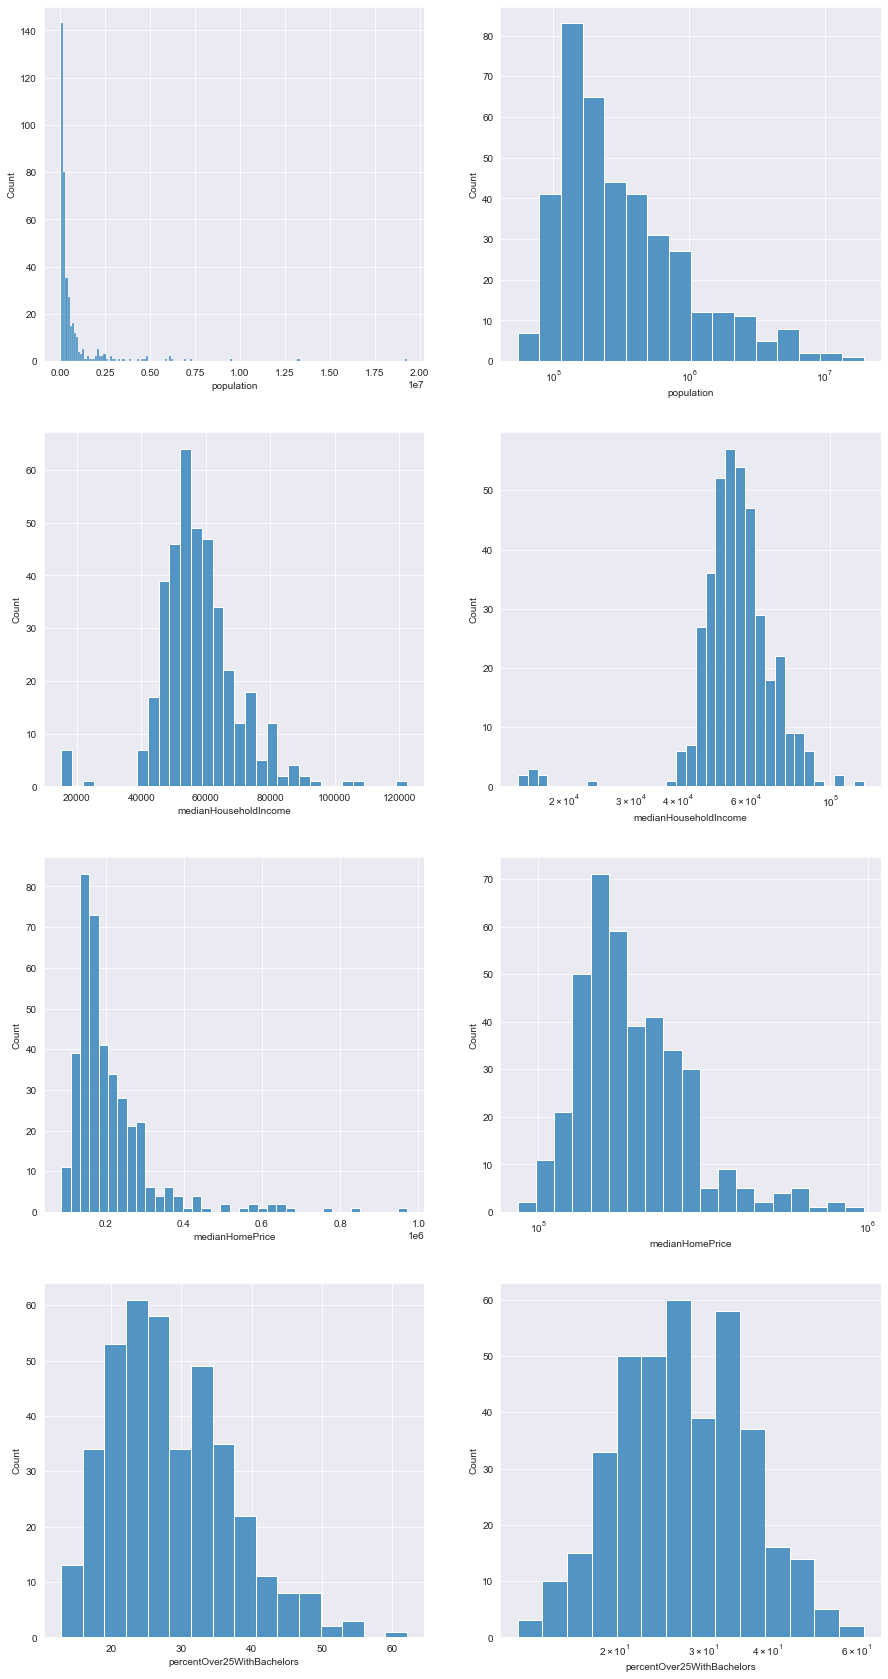

In [73]:
fig, axes = plt.subplots(4, 2)
fig.set_size_inches(15,30)
for i in range(1,5):
    sns.histplot(pd_msa_df.iloc[:,i], ax=axes[i-1,0])
    sns.histplot(pd_msa_df.iloc[:, i], log_scale=True, ax=axes[i-1,1])

That log transformation looks like it will help. Run the Cypher to store the transformed values in the graph.

In [75]:
gdbClient.queryToPrint("""
MATCH (m:MSA)
SET 
m.logPopulation = log(m.population),
m.logMedianHouseholdIncome = log(m.medianHouseholdIncome),
m.logMedianHomePrice = log(m.medianHomePrice),
m.logPercentOver25WithBachelors = log(m.percentOver25WithBachelors)
""")

Empty DataFrame
Columns: []
Index: []


That log transformation looks like it will help. Run the Cypher to store the transformed values in the graph.

In [80]:
log_update = """
MATCH (m:MSA)
SET
m.logPopulation = log(m.population),
m.logMedianHouseholdIncome = log(m.medianHouseholdIncome),
m.logMedianHomePrice = log(m.medianHomePrice),
m.logPercentOver25WithBachelors = log(m.percentOver25WithBachelors)
RETURN m.name AS msa,m.logPopulation,m.logMedianHouseholdIncome,m.logMedianHomePrice,m.logPercentOver25WithBachelors
"""

gdbClient.queryToPrint(log_update)

                                                           msa  m.logPopulation  m.logMedianHouseholdIncome  m.logMedianHomePrice  m.logPercentOver25WithBachelors
0                                       Abilene, TX Metro Area        12.047481                   10.868778             11.869900                         3.135494
1                             Aguadilla-Isabela, PR Metro Area        12.615221                    9.709296             11.744037                         3.030134
2                                         Akron, OH Metro Area        13.464313                   10.955794             11.962726                         3.456317
3                                        Albany, GA Metro Area        11.907909                   10.710945             11.788282                         2.995732
4                                Albany-Lebanon, OR Metro Area        11.736453                   10.931194             12.322966                         2.960105
5                     

Check that log attributes were populated

# Create in-memory graph projection
Passing `"*"` as the third argument to `gds.graph.project` tells GDS to include any relationships that exist in the database in the in-memory graph. Because no relationships have been created in the graph yet, there will be no relationships in the in-memory graph projection when it is created.

In [81]:
graph_project_query = """
    CALL gds.graph.project(
    'msa-graph',
    'MSA',
    '*',
    {nodeProperties: ["logPopulation",
        "logMedianHouseholdIncome",
        "logMedianHomePrice",
        "logPercentOver25WithBachelors"]})
"""

gdbClient.queryToPrint(graph_project_query)

Query failed: Failed to invoke procedure `gds.graph.project`: Caused by: java.lang.IllegalArgumentException: A graph with name 'msa-graph' already exists.


AttributeError: 'NoneType' object has no attribute 'to_string'

Notice that when we look at the results of `gds.graph.project`, we see that the `relationshipCount` is 0.

# Apply MinMax scalar to property values

In [82]:
graph_scale_properties_mutations = """
CALL gds.alpha.scaleProperties.mutate("msa-graph", {
                                 nodeProperties: [
                                     "logPopulation",
                                     "logMedianHouseholdIncome",
                                     "logMedianHomePrice",
                                     "logPercentOver25WithBachelors"],
                                 scaler : "MinMax",
                                 mutateProperty : "scaledProperties"
                                 })
                                 """

gdbClient.queryToPrint(graph_scale_properties_mutations)

Query failed: Failed to invoke procedure `gds.alpha.scaleProperties.mutate`: Caused by: java.lang.IllegalArgumentException: Node property `scaledProperties` already exists in the in-memory graph.


AttributeError: 'NoneType' object has no attribute 'to_string'

This next line streams node properties to the procedure caller.

In [83]:
graph_stream_scaled_properties_query = """
CALL gds.graph.streamNodeProperty('msa-graph', 'scaledProperties')
YIELD nodeId, propertyValue
RETURN nodeId, propertyValue
                                 """
pandas_sp_df = gdbClient.queryToDf(graph_stream_scaled_properties_query)
pandas_sp_df


,nodeId,propertyValue
0,0,"[0.19380252950086857, 0.5941656109985317, 0.20..."
1,1,"[0.2906143313546108, 0.038547641095507214, 0.1..."
2,2,"[0.43540282570845074, 0.635863304083786, 0.244..."
3,3,"[0.17000248708123394, 0.5185328975653707, 0.17..."
4,4,"[0.1407655201423013, 0.6240752711480254, 0.394..."
...,...,...
387,387,"[0.08584996953919312, 0.008315006694319935, 0...."
388,388,"[0.3574378498156289, 0.7070315697941265, 0.315..."
389,389,"[0.39079844582939915, 0.5446912822037772, 0.12..."
390,390,"[0.19559155580908621, 0.6463381988019842, 0.48..."


<AxesSubplot:>

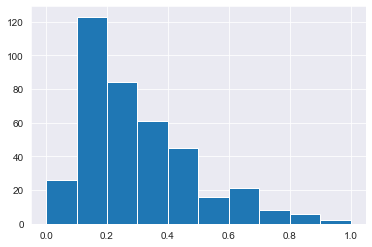

In [84]:
pd.DataFrame(list(pandas_sp_df['propertyValue'])).iloc[:,0].hist()

<AxesSubplot:>

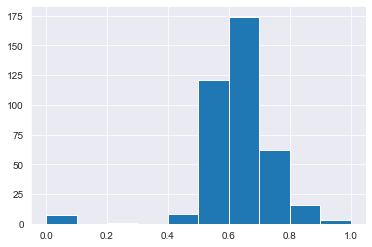

In [85]:
pd.DataFrame(list(pandas_sp_df['propertyValue'])).iloc[:,1].hist()

<AxesSubplot:>

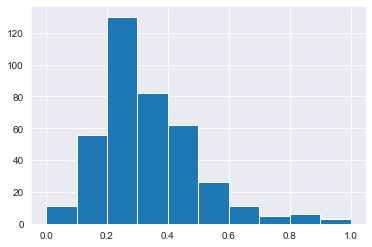

In [50]:
pd.DataFrame(list(pandas_sp_df['propertyValue'])).iloc[:,2].hist()

<AxesSubplot:>

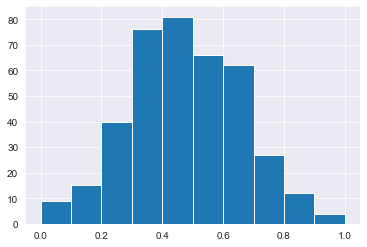

In [51]:
pd.DataFrame(list(pandas_sp_df['propertyValue'])).iloc[:,3].hist()

# Run KNN to create relationships to nearest neighbors
First run in stats mode and look at the similarity distribution.

In [87]:
knn_stats_query = """CALL gds.knn.stats("msa-graph",
   {
      nodeProperties:{
      scaledProperties:"EUCLIDEAN"},
      topK:15,
      similarityCutoff: 0.8350143432617188,
      sampleRate:1,
      randomSeed:42,
      concurrency:1
   }
)
YIELD similarityDistribution
RETURN similarityDistribution """

knn_stats=gdbClient.query(knn_stats_query)
print(knn_stats)

[<Record similarityDistribution={'p1': 0.88128662109375, 'max': 0.9999847412109375, 'p5': 0.9450721740722656, 'p90': 0.9963340759277344, 'p50': 0.9896583557128906, 'p95': 0.9976234436035156, 'p10': 0.9648170471191406, 'p75': 0.993865966796875, 'p99': 0.998992919921875, 'p25': 0.9818534851074219, 'p100': 0.9999847412109375, 'min': 0.8350143432617188, 'mean': 0.9832137070829129, 'stdDev': 0.020862493999870387}>]


Now run KNN in mutate mode to update the in-memory graph projection. We'll exclude the bottom 1% of similarity relationships.

In [88]:
knn_write = f"""CALL gds.knn.mutate("msa-graph",
               {{nodeProperties: {{scaledProperties: "EUCLIDEAN"}},
               topK: 15,
               mutateRelationshipType: "IS_SIMILAR",
               mutateProperty: "similarity",
               similarityCutoff: {knn_stats[0]['similarityDistribution']['p1']},
               sampleRate:1,
               randomSeed:42,
               concurrency:1}}
              ) """

print(knn_write)

gdbClient.queryToPrint(knn_write)

CALL gds.knn.mutate("msa-graph",
               {nodeProperties: {scaledProperties: "EUCLIDEAN"},
               topK: 15,
               mutateRelationshipType: "IS_SIMILAR",
               mutateProperty: "similarity",
               similarityCutoff: 0.88128662109375,
               sampleRate:1,
               randomSeed:42,
               concurrency:1}
              ) 
Query failed: Failed to invoke procedure `gds.knn.mutate`: Caused by: java.lang.IllegalArgumentException: Relationship type `IS_SIMILAR` already exists in the in-memory graph.


AttributeError: 'NoneType' object has no attribute 'to_string'

Also write the relationships from the in-memory graph projection back to the on-disk graph.

In [89]:
similarity_relationship_writeback = """CALL gds.graph.writeRelationship(
    "msa-graph",
    "IS_SIMILAR",
    "similarity"
)"""

gdbClient.queryToPrint(similarity_relationship_writeback)

   writeMillis  graphName relationshipType relationshipProperty  relationshipsWritten  propertiesWritten
0          319  msa-graph       IS_SIMILAR           similarity                  5765               5765


Add a `rank` property to the `IS_SIMILAR` relationships for use with Bloom filtering.

In [91]:
add_rank_update = """
MATCH (m:MSA)-[s:IS_SIMILAR]->()
WITH m, s ORDER BY s.similarity DESC
WITH m, collect(s) as similarities, range(0, 11) AS ranks
UNWIND ranks AS rank
WITH rank, similarities[rank] AS rel
SET rel.rank = rank + 1
"""

gdbClient.queryToPrint(add_rank_update)

Empty DataFrame
Columns: []
Index: []


# Run Louvain community detection

In [92]:
read_louvain = """
CALL gds.louvain.stats('msa-graph',
{relationshipTypes: ["IS_SIMILAR"],
relationshipWeightProperty:"similarity"})
YIELD communityCount, modularities
RETURN communityCount, modularities
"""
gdbClient.queryToPrint(read_louvain)

   communityCount                              modularities
0               9  [0.6299828070742017, 0.6543719938451087]


Now commit louvain communities to database

In [93]:
write_louvain = """
CALL gds.louvain.write('msa-graph',
{relationshipTypes: ["IS_SIMILAR"],
relationshipWeightProperty:"similarity",
 writeProperty:"communityId"})
YIELD communityCount, modularities
RETURN communityCount, modularities
"""

gdbClient.queryToPrint(write_louvain)

   communityCount                              modularities
0               9  [0.6299828070742017, 0.6543719938451087]


# Gather statistics about the communities that were discovered

Get average values for each community and 3 example MSAs for each community.

In [94]:
community_query = """
MATCH (m:MSA)
WITH m 
ORDER BY apoc.coll.sum([(m)-[s:IS_SIMILAR]->(m2) 
WHERE m.communityId = m2.communityId | s.similarity]) desc
RETURN m.communityId as communityId,
count(m) as msaCount, 
avg(m.population) as avgPopulation,
avg(m.medianHomePrice) as avgHomePrice,
avg(m.medianHouseholdIncome) as avgIncome,
avg(m.percentOver25WithBachelors) as avgPctBachelors,
collect(m.name)[..3] as exampleMSAs
ORDER BY avgPopulation DESC
"""
pd_community = gdbClient.queryToDf(community_query)
pd_community

,communityId,msaCount,avgPopulation,avgHomePrice,avgIncome,avgPctBachelors,exampleMSAs
0,315,1,2.100207e+06,140600.000000,23156.000000,28.000000,"[San Juan-Bayamón-Caguas, PR Metro Area]"
1,83,49,1.916216e+06,411930.612245,78436.734694,39.248980,"[Colorado Springs, CO Metro Area, Oxnard-Thous..."
2,56,79,1.678945e+06,203273.417722,60116.164557,31.040506,"[Little Rock-North Little Rock-Conway, AR Metr..."
3,333,28,4.606980e+05,149510.714286,48965.928571,21.325000,"[Flint, MI Metro Area, Corpus Christi, TX Metr..."
4,254,53,2.334595e+05,167798.113208,55711.245283,26.894340,"[Tyler, TX Metro Area, South Bend-Mishawaka, I..."
5,277,71,1.754926e+05,237325.352113,61466.591549,35.415493,"[Pittsfield, MA Metro Area, Blacksburg-Christi..."
6,100,41,1.612953e+05,161904.878049,49128.707317,16.965854,"[Anniston-Oxford, AL Metro Area, Gadsden, AL M..."
7,313,7,1.569859e+05,113228.571429,16556.857143,22.400000,"[San Germán, PR Metro Area, Arecibo, PR Metro ..."
8,266,63,1.336109e+05,150033.333333,52001.047619,22.025397,"[Lawton, OK Metro Area, Watertown-Fort Drum, N..."


In [95]:
pd_community.sort_values('communityId')

,communityId,msaCount,avgPopulation,avgHomePrice,avgIncome,avgPctBachelors,exampleMSAs
2,56,79,1.678945e+06,203273.417722,60116.164557,31.040506,"[Little Rock-North Little Rock-Conway, AR Metr..."
1,83,49,1.916216e+06,411930.612245,78436.734694,39.248980,"[Colorado Springs, CO Metro Area, Oxnard-Thous..."
6,100,41,1.612953e+05,161904.878049,49128.707317,16.965854,"[Anniston-Oxford, AL Metro Area, Gadsden, AL M..."
4,254,53,2.334595e+05,167798.113208,55711.245283,26.894340,"[Tyler, TX Metro Area, South Bend-Mishawaka, I..."
8,266,63,1.336109e+05,150033.333333,52001.047619,22.025397,"[Lawton, OK Metro Area, Watertown-Fort Drum, N..."
5,277,71,1.754926e+05,237325.352113,61466.591549,35.415493,"[Pittsfield, MA Metro Area, Blacksburg-Christi..."
7,313,7,1.569859e+05,113228.571429,16556.857143,22.400000,"[San Germán, PR Metro Area, Arecibo, PR Metro ..."
0,315,1,2.100207e+06,140600.000000,23156.000000,28.000000,"[San Juan-Bayamón-Caguas, PR Metro Area]"
3,333,28,4.606980e+05,149510.714286,48965.928571,21.325000,"[Flint, MI Metro Area, Corpus Christi, TX Metr..."


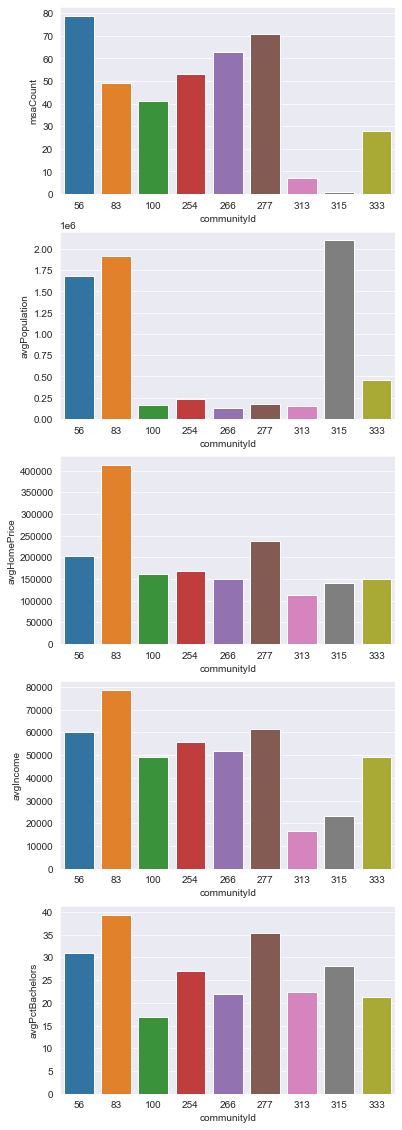

In [97]:
fig, axes = plt.subplots(5, 1)
fig.set_size_inches(6,20)
for i in range(1,6):
    sns.barplot(data=pd_community, x="communityId", y=pd_community.columns[i], ax=axes[i-1])

Mean can give us a quick overview of properties, but can be skewed by outliers. Compare emperical cumulative distribution function (ECDF) at various proportions to get a more complete picture of distributions.

In [100]:
# we need to remove sort by here
detail_query="""
MATCH (m:MSA)
RETURN "community " + m.communityId as communityId,
m.population as population,
m.medianHomePrice as medianHomePrice,
m.medianHouseholdIncome as medianIncome,
m.percentOver25WithBachelors as pctBachelors
order by communityId ASC
"""

## post sorting in spark

pd_detail =gdbClient.queryToDf(detail_query)

In [101]:
print(pd_detail)

       communityId  population  medianHomePrice  medianIncome  pctBachelors
0    community 100      148436           131700         44844          20.0
1    community 100      153310           154500         46367          19.0
2    community 100      114618           133800         47255          18.5
3    community 100      104104           104100         48819          19.3
4    community 100      118828           121000         42817          17.1
..             ...         ...              ...           ...           ...
387   community 83      367922           291100         81057          42.6
388   community 83      984821           673400         85857          35.0
389   community 83      441829           419700         81472          26.9
390   community 83     6196585           425300        103751          50.9
391   community 83      941338           274000         73408          34.9

[392 rows x 5 columns]


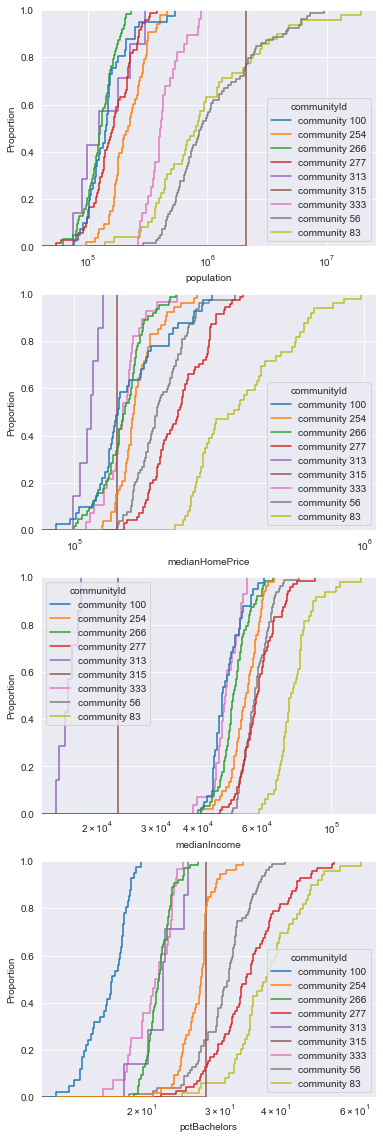

In [102]:
fig, axes = plt.subplots(4, 1)
fig.set_size_inches(6,20)
for i in range(1,5):
    sns.ecdfplot(data=pd_detail, hue="communityId", x=pd_detail.columns[i], log_scale=True, ax=axes[i-1])

Compare two-dimensions on scatter plots

[None]

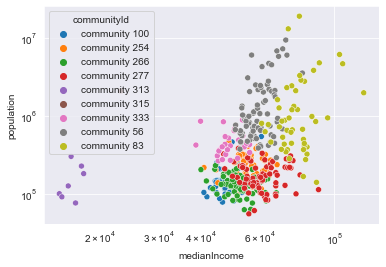

In [103]:
splot = sns.scatterplot(data=pd_detail, x="medianIncome", y="population", hue="communityId")
splot.set(yscale="log")
splot.set(xscale="log")

[None]

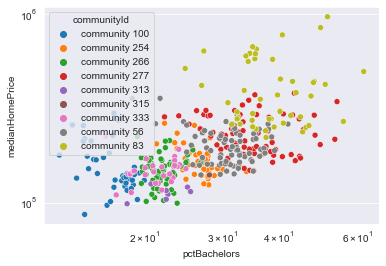

In [104]:
splot = sns.scatterplot(data=pd_detail, x="pctBachelors", y="medianHomePrice", hue="communityId")
splot.set(yscale="log")
splot.set(xscale="log")

# Assign human-friendly names to the clusters discovered.
The Louvain community detection algorithm is not deterministic. You should have roughly the same clusters from previous runs, but some edge cases might be assigned to different communities. The community numbers might be shuffled between across different runs.
**This step requires adjustment by hand: choose from community IDs above.**

In [107]:
gdbClient.queryToPrint("""
MATCH (m:MSA) 
  SET m.communityName = CASE m.communityId 
  WHEN 56 THEN "Large mid-cost metros"
  WHEN 83 THEN "College towns"
  WHEN 100 THEN "Large high-cost metros"
  WHEN 254 THEN "Mid-size metros"
  WHEN 266 THEN "Small metros"
  WHEN 377 THEN "Mid-price metros"
  WHEN 313 THEN "Low-income metros"
  END
return m.communityName, m.communityId, count(*)
""")

          m.communityName  m.communityId  count(*)
0            Small metros            266        63
1       Low-income metros            313         7
2   Large mid-cost metros             56        79
3  Large high-cost metros            100        41
4           College towns             83        49
5         Mid-size metros            254        53
6                    None            277        71
7                    None            333        28
8                    None            315         1


Create an index on the `communityName` property to make it searchable in Bloom.

In [108]:
gdbClient.query("""
CREATE INDEX msa_community_name IF NOT EXISTS
FOR (m:MSA)
ON (m.communityName)
""")

[]